In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy
from gurobipy import *
import numpy as np
import pandas as pd


import yaml
from inspect import getsourcefile
import os.path
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
current_path = os.path.abspath(getsourcefile(lambda:0))
current_dir = os.path.dirname(current_path)
parentdir = os.path.dirname(current_dir)
sys.path.insert(0,parentdir) 
sys.path.insert(0, parentdir+"/heuristics")
sys.path.insert(0, parentdir+"/heuristics/LP-Models")
sys.path.insert(0, parentdir+"/fast_gradient")


from fast_group import FastDynamicalModel
from aux import *

from copy import deepcopy
import copy
import math
import matplotlib.dates as mdates

%matplotlib inline

{'groups': 'all', 'params_to_try': {'delta_schooling': [0.5, 1, 5], 'xi': [0, 371990.3, 929975.75, 1859951.5, 3719903, 5579854.5], 'icus': [2900], 'tests': [[0, 0], [30000, 0]], 'testing': ['homogeneous'], 'eta': [0, 0.2]}}
{'groups': 'all', 'params_to_try': {'delta_schooling': [0.5, 1, 5], 'xi': [0, 371990.3, 929975.75, 1859951.5, 3719903, 5579854.5], 'icus': [2900], 'tests': [[0, 0], [30000, 0]], 'testing': ['homogeneous'], 'eta': [0, 0.2]}}


In [2]:
0.05/2/np.sqrt(3)

0.014433756729740645

In [2]:
age_groups = ['age_group_0_9', 'age_group_10_19', 'age_group_20_29','age_group_30_39', 'age_group_40_49', 'age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
old_age_groups = ['age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
econ_activities = ['transport', 'leisure', 'other']
cont = [ 'S', 'E', 'I', 'R', 'N', 'Ia', 'Ips', \
           'Ims', 'Iss', 'Rq', 'H', 'ICU', 'D' ]

In [3]:
data = pd.read_csv("donnees-hospitalieres-classe-age-covid19-2020-10-28-19h00.csv", sep=";")
data.head()

,reg,cl_age90,jour,hosp,rea,rad,dc
0,1,0,2020-03-18,0,0,0,0
1,1,9,2020-03-18,0,0,0,0
2,1,19,2020-03-18,0,0,0,0
3,1,29,2020-03-18,0,0,0,0
4,1,39,2020-03-18,0,0,0,0


In [4]:
# Load the data
google = pd.read_csv("2020_FR_Region_Mobility_Report.csv")
google = google[google['sub_region_1']=="Île-de-France"]
google = google[pd.isnull(google['sub_region_2'])]

In [5]:
# Apply an smoothing to the data
initial_work = ((google["workplaces_percent_change_from_baseline"]+100)/100).values
google_days = [datetime.strptime(google["date"].values[i], '%Y-%m-%d').weekday() for i in range(len(google["date"]))]
new_work = []
for i in range(len(initial_work)):
    if google_days[i]<=4:
        new_work.append(initial_work[i])
    elif google_days[i]==5:
        numbers_for_mean = []
        for k in range(i-5,i):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+2,i+7):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))
    elif google_days[i]==6:
        numbers_for_mean = []
        for k in range(i-6,i-1):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+1,i+6):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))


In [6]:
# Assign data
google['work'] = new_work
google['transport'] = (google["transit_stations_percent_change_from_baseline"]+100)/100
google['other'] = 0.33*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+0.67*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
google['leisure'] = 0.33*(google["parks_percent_change_from_baseline"]+100)/100+0.67*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100
google = google.reset_index()
google.to_csv('smoothed.csv')



In [7]:
# Extract days 
data = data[data['jour']<='2020-10-21']
french_days = data[data['reg']==11][data['cl_age90']==0].jour.values

/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Extract data from french dataset
deaths_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].dc.values for i in range(0,9)
}
deaths_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].dc.values
deaths_real['total']=data[data['reg']==11][data['cl_age90']==0].dc.values


icus_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
icus_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].rea.values
icus_real['total']=data[data['reg']==11][data['cl_age90']==0].rea.values


beds_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].hosp.values-data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
beds_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].hosp.values - data[data['reg']==11][data['cl_age90']==90].rea.values
beds_real['total']=data[data['reg']==11][data['cl_age90']==0].hosp.values - data[data['reg']==11][data['cl_age90']==0].rea.values

/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys

In [9]:
# Load the original SEIR parameters
params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params", index_col = 0)
initial_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values,
    "lambda_ICU":params['lambda_ICU'].values,
    "lambda_H":params['lambda_H'].values,
    "p_death":params['p_death_cond_ss'].values,
    "p_recov":params['p_recov_cond_ss'].values,
    
}

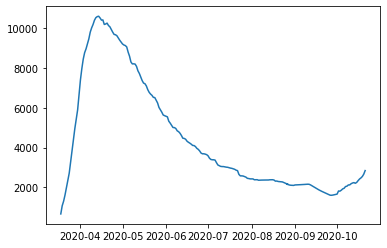

In [10]:
# Smooth the french data
start_smooth = datetime.strptime("2020-09-01", '%Y-%m-%d')
end_smooth = datetime.strptime("2020-10-01", '%Y-%m-%d')
for ag in beds_real:
    new_series = []
    for i in range(len(beds_real[ag])):
        day = datetime.strptime(french_days[i], '%Y-%m-%d')
        lower = (day-start_smooth).days
        upper = (end_smooth-day).days
        if lower>=0 and upper>=0:
            n_days_before = min(lower,7)
            n_days_after = min(upper,7)
            avg_value = np.mean(beds_real[ag][(i-n_days_before):(i+1+n_days_after)])
            new_series.append(avg_value)
        else:
            new_series.append(beds_real[ag][i])
    beds_real[ag] = np.array(new_series)
        

plt.figure(1)
plt.plot([datetime.strptime(d, '%Y-%m-%d') for d in french_days],beds_real["total"])


In [11]:
region = "Ile-de-France"

# Read group parameters
with open("../parameters/"+region+".yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)
    
# Read initialization
with open("../initialization/patient_zero.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    original_initialization = yaml.load(file, Loader=yaml.FullLoader)

# Read econ parameters
with open("../parameters/econ.yaml") as file:
    econ_params = yaml.load(file, Loader=yaml.FullLoader)

experiment_params = {
    'delta_schooling':0.5,
    'xi':0,
    'icus':4000,
}

In [12]:
# Create relevant dates
date_1 = datetime.strptime("2020-03-17", '%Y-%m-%d')
date_2 = datetime.strptime("2020-05-11", '%Y-%m-%d')
date_3 = datetime.strptime("2020-07-01", '%Y-%m-%d')
date_4 = datetime.strptime("2020-09-01", '%Y-%m-%d')
final_date = datetime.strptime("2020-10-21", '%Y-%m-%d')

rates_date = datetime.strptime("2020-03-01", '%Y-%m-%d')

first_day_google = datetime.strptime("2020-02-15", '%Y-%m-%d')
days_between_google = (date_1-first_day_google).days


In [13]:
# Fill up the original parameters
original_beta = universe_params['seir-groups']["age_group_0_9"]["parameters"]["beta"]
t_days_beta = 730

for ag in universe_params['seir-groups']:
    universe_params['seir-groups'][ag]["parameters"]["beta"] = (
        [original_beta for t in range(t_days_beta) ]
    )


In [14]:
# Create model
mixing_method = {}
dynModel = FastDynamicalModel(universe_params, econ_params, experiment_params, 1, mixing_method, 1e9, 0, 0)


In [15]:
# Generate samples
np.random.seed(0)
n_samples = 1
samples = 1+np.random.randn(n_samples,(final_date-date_1).days+150, 5)*0.05/2/np.sqrt(3)

In [16]:
best_v = 0
best_error = float('inf')
validation_date = datetime.strptime("2020-10-21", '%Y-%m-%d')
# This is the smoothening
trans_days = 15

def error(v):
    
    vector_upper_model_data_beds = []
    vector_upper_model_data_deaths = []
    vector_upper_model_data_icus = []
    vector_errors = []
    vector_errors_dict = []
    
    for n_sample in range(n_samples):
        days_ahead = v[0]
        alpha_mixing = v[1]
        
        beta_normal = original_beta
        beta_masks = beta_normal*v[2]
        
        mix_1 = v[3]
        mix_2 = 0
        
        alphas_d = {
            'work':alpha_mixing,
            'transport':alpha_mixing,
            'school':alpha_mixing,
            'other':alpha_mixing,
            'leisure':alpha_mixing,
            'home':alpha_mixing,
        }

        # School lockdowns
        school_lockdown = v[4]
        school_may_jun = v[5]
        school_jul_aug = v[6]
        school_sep_oct = v[7]

        # Changes to SEIR rates
        fraction_p_ICU = v[8]
        change_lambda_H_aft = v[9]
        change_lambda_ICU_aft = v[10]
        change_p_death_aft = v[11]
        
        # Date that a change occurs
        days_change_rates = v[12]


        google['other'] = mix_1*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+(1-mix_1)*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
        google['leisure'] = mix_2*(google["parks_percent_change_from_baseline"]+100)/100+(1-mix_2)*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100


        # Number of days
        days_before_date_1 = int(days_ahead)
        days_between_dates_1_2 = (date_2-date_1).days
        days_between_dates_2_3 = (date_3-date_2).days
        days_between_dates_3_4 = (date_4-date_3).days
        days_after_date_4 = (final_date-date_4).days
        total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_after_date_4
        validation_days = days_before_date_1 + (final_date-date_1).days
        
        # Some additional calculations
        days_rates_start = (rates_date - date_1).days + days_ahead

        # Construct initialization
        initialization = deepcopy(original_initialization)
        for i,group in enumerate(age_groups):
            if group == "age_group_40_49":
                initialization[group]["I"] = initialization[group]["I"] + 1
                initialization[group]["S"] = initialization[group]["S"] - 1
            initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]


        # Alphas
        a_before_google = {
            'home':1.0,
            'leisure':1.0,
            'other':1.0,
            'school':1.0,
            'transport':1.0,
            'work':1.0
        }



        # Calculate alphas
        alphas_vec = []
        for t in range(days_before_date_1-days_between_google):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = a_before_google
            alphas_vec.append(alphas)

        counter = 0
        for t in range(days_between_google):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':1.0,
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
            
        for t in range(days_between_dates_1_2):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_lockdown*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
            
        for t in range(days_between_dates_2_3):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_may_jun*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1

        for t in range(days_between_dates_3_4):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_jul_aug*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
            
        for t in range(days_after_date_4):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_sep_oct*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)
            counter += 1

        # Calculate tests
        tests = np.zeros(len(age_groups))


        # Run model
        model_data_beds = {ag:[] for ag in age_groups+["total"]}
        model_data_icus = {ag:[] for ag in age_groups+["total"]}
        model_data_deaths = {ag:[] for ag in age_groups+["total"]}

        state = state_to_matrix(initialization)
        t_beds = 0
        t_icus = 0
        t_deaths = 0
        for i,ag in enumerate(age_groups):
            state_H = state[i,cont.index("H")]
            state_ICU = state[i,cont.index("ICU")]
            state_D = state[i,cont.index("D")]
            model_data_beds[ag].append(state_H)
            model_data_icus[ag].append(state_ICU)
            model_data_deaths[ag].append(state_D)
            t_beds+= state_H
            t_icus+= state_ICU
            t_deaths+= state_D
        model_data_beds["total"].append(t_beds)
        model_data_icus["total"].append(t_icus)
        model_data_deaths["total"].append(t_deaths)


        dynModel.beta = np.zeros((len(age_groups),len(dynModel.groups[age_groups[0]].parameters["beta"])))
        for i in range(len(age_groups)):
            for j in range(len(dynModel.groups[age_groups[0]].parameters["beta"])):
                if j < int(days_rates_start+days_change_rates):
                    dynModel.beta[i,j] = beta_normal
                else:
                    d_after = j-int(days_rates_start+days_change_rates)
                    d_portion = max(trans_days-d_after,0)/trans_days
                    dynModel.beta[i,j] = beta_normal*d_portion+beta_masks*(1-d_portion)

        for t in range(total_days):
            current_date = date_1+timedelta(days=t-days_before_date_1)
            day_of_week = current_date.weekday()

            update_contacts = True
                
            if t<int(days_rates_start+days_change_rates):
                dynModel.p_H = initial_params["p_H"]
                dynModel.p_ICU = initial_params["p_ICU"]

                lambda_H = initial_params["lambda_H"]
                lambda_ICU = initial_params["lambda_ICU"]
                p_death = initial_params["p_death"]
                
                dynModel.lambda_H_D = p_death*lambda_H
                dynModel.lambda_H_R = (1-p_death)*lambda_H
                dynModel.lambda_ICU_D = p_death*lambda_ICU
                dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU

            else:
                d_after = t-int(days_rates_start+days_change_rates)
                d_portion = max(trans_days-d_after,0)/trans_days
                
                dynModel.p_ICU = initial_params["p_ICU"]*d_portion+initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion)
                dynModel.p_H = (initial_params["p_H"]+initial_params["p_ICU"])-(initial_params["p_ICU"]*d_portion+initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion))

                lambda_H = initial_params["lambda_H"]*d_portion+initial_params["lambda_H"]*change_lambda_H_aft*(1-d_portion)
                lambda_ICU = initial_params["lambda_ICU"]*d_portion+ initial_params["lambda_ICU"]*change_lambda_ICU_aft*(1-d_portion)
                p_death = initial_params["p_death"]*d_portion+initial_params["p_death"]*change_p_death_aft*(1-d_portion)
                
                dynModel.lambda_H_D = p_death*lambda_H
                dynModel.lambda_H_R = (1-p_death)*lambda_H
                dynModel.lambda_ICU_D = p_death*lambda_ICU
                dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU
                
                
            

            season = "spc"
            dynModel.mixing_method = {
                    "name":"mult",
                    "param_alpha":alphas_d,
                    "param_beta":alphas_d,
                }
            
            state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]), t, season, update_contacts=update_contacts)
            t_beds = 0
            t_icus = 0
            t_deaths = 0
            for i,ag in enumerate(age_groups):
                state_H = state[i,cont.index("H")]
                state_ICU = state[i,cont.index("ICU")]
                state_D = state[i,cont.index("D")]
                model_data_beds[ag].append(state_H)
                model_data_icus[ag].append(state_ICU)
                model_data_deaths[ag].append(state_D)
                t_beds+= state_H
                t_icus+= state_ICU
                t_deaths+= state_D
            #print(t_beds)
            model_data_beds["total"].append(t_beds)
            model_data_icus["total"].append(t_icus)
            model_data_deaths["total"].append(t_deaths)


        initial_date = date_1-timedelta(days=days_before_date_1)

        # Calculate the days of the model
        days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

        # Indices where to put the real data
        indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in french_days]

        # Real data
        real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
        real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
        real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}

        for k,ind in enumerate(indices):
            for ag in age_groups+["total"]:
                real_data_beds[ag][ind] = beds_real[ag][k] if beds_real[ag][k]!=0 else float('nan')
                real_data_icus[ag][ind] = icus_real[ag][k] if icus_real[ag][k]!=0 else float('nan')
                real_data_deaths[ag][ind] = deaths_real[ag][k] if deaths_real[ag][k]!=0 else float('nan')


        tail_constant = 0.5
        peak_constant = 0.25
        error_beds = 0
        error_icus = 0
        error_deaths = 0
        
        peak_beds = np.nanargmax(np.array(real_data_beds["total"]))
        peak_icus = np.nanargmax(np.array(real_data_icus["total"]))
        peak_deaths = peak_beds+30
        
        #         for ag in old_age_groups:
        #             error_beds += np.nanmean((np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag]))/np.array(real_data_beds[ag]))[0:validation_days-1])
        #             error_icus += np.nanmean((np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag]))/np.array(real_data_icus[ag]))[0:validation_days-1])
        #             error_deaths += np.nanmean((np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag]))/np.array(real_data_deaths[ag]))[0:validation_days-1])
        error_beds_total = np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[0:validation_days-14])
        error_beds_tail = tail_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[validation_days-14:validation_days])
        error_beds_peak = peak_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[peak_beds:peak_beds+1])
                              
        error_icus_total = 0.5*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[0:validation_days-14])
        error_icus_tail = 2*tail_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[validation_days-14:validation_days])
        error_icus_peak = 0.5*peak_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[peak_icus:peak_icus+1])

                              
        error_deaths_total = np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[0:validation_days-14])
        error_deaths_tail = tail_constant*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[validation_days-14:validation_days])
        error_deaths_peak = peak_constant*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_deaths:peak_deaths+1])
        #         error_deaths_total += error_constant/4.0*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_beds:peak_beds+1])

        #overflow = np.array(model_data_icus["total"]) - icu_bound
        #overflow_error = np.nanmean([max(overflow[i],0) for i in range(len(overflow))])


        upper_days_model = days_model
        
        error = error_beds_total+error_beds_tail+error_beds_peak+error_icus_total+error_icus_tail+error_icus_peak+error_deaths_total+error_deaths_tail+error_deaths_peak

        error_dict = {
            "beds_total":error_beds_total/error,
            "beds_tail":error_beds_tail/error,
            "beds_peak":error_beds_peak/error,
            "icus_total":error_icus_total/error,
            "icus_tail":error_icus_tail/error,
            "icus_peak":error_icus_peak/error,
            "deaths_total":error_deaths_total/error,
            "deaths_tail":error_deaths_tail/error,
            "deaths_peak":error_deaths_peak/error,
        }
        print(error_dict)
        
        vector_errors.append(error)
        vector_errors_dict.append(error_dict)
        vector_upper_model_data_beds.append(model_data_beds["total"])
        vector_upper_model_data_deaths.append(model_data_deaths["total"])
        vector_upper_model_data_icus.append(model_data_icus["total"])
        

    error = np.mean(vector_errors)

    
    global best_error
    global best_v
    if error<best_error:
        best_error = error
        print("best_error:",best_error)
        print("vector:",vector_errors)
        print("dict:",vector_errors_dict)
        best_v = v
        print(v)

        print("Beds")
        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data_beds[n_sample], label="Prediction")
        plt.plot(upper_days_model, real_data_beds["total"], label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        
        print("Deaths")
        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data_deaths[n_sample], label="Prediction")
        plt.plot(upper_days_model, real_data_deaths["total"], label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        
        print("ICUs")
        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data_icus[n_sample], label="Prediction")
        plt.plot(upper_days_model, real_data_icus["total"], label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        
        

    return error





In [17]:
deaths_change = [deaths_real["total"][i+1]-deaths_real["total"][i] for i in range(len(deaths_real["total"])-1)]
print(deaths_change)

[37, 26, 27, 22, 45, 69, 95, 103, 118, 110, 119, 147, 222, 193, 202, 220, 176, 140, 248, 272, 223, 190, 260, 116, 132, 156, 233, 203, 179, 191, 154, 92, 186, 152, 125, 111, 122, 64, 62, 112, 153, 95, 109, 38, 31, 92, 77, 62, 43, 31, 30, 23, 54, 66, 33, 36, 31, 16, 17, 39, 50, 28, 23, 31, 9, 11, 32, 38, 26, 23, 16, 38, 15, 13, 28, 35, 12, 11, 20, 5, 14, 30, 9, 12, 15, 15, 3, 11, 19, 11, 4, 2, 8, 2, 8, 14, 0, 7, 11, 2, 0, 4, 10, 2, 5, 6, 6, 0, 4, 16, 9, 5, 2, 2, 0, 8, 2, 5, 6, 1, 3, 0, 5, 5, 0, 5, 3, 4, 0, 2, 9, 7, 4, 2, 1, 1, 12, 4, 4, 4, 8, 1, 0, 4, 3, 9, 4, 3, 1, 0, 8, 8, 6, 6, 15, 5, 1, 2, 2, 18, -6, 12, 1, 2, 11, 6, 14, 7, 6, 1, 0, 5, 8, 7, 6, 5, 6, 2, 9, 10, 29, 13, 85, 8, 5, 8, 18, 14, 15, 7, 11, 11, 25, 11, 20, 15, 14, 13, 5, 24, 15, 21, 24, 17, 14, 11, 32, 27, 19, 29, 21, 22, 27, 36, 38, 34]


In [18]:
# Construct the windows for the parameters to move
windows = {}
# for p in initial_params:
#     windows[p] = (
#         np.min(upper_params[p]/initial_params[p]),
#         np.max(lower_params[p]/initial_params[p]),
#     )

windows['days_ahead'] = (50,100)
windows['alpha_mixing'] = (0.1,2.0)
windows['beta_transmission'] = (0.5,2.0)
windows['mix'] = (0.0,1.0)
windows['school_lockdown'] = (0,0.1)
windows['school_may_jun'] = (0,1)
windows['school_jul_aug'] = (0,0.2)
windows['school_sep_oct'] = (0.5,1.0)
windows['change_rates'] = (0,60)
windows['SEIR_changes'] = (0.5,2.0)



In [19]:
from scipy.optimize import minimize, Bounds, shgo, differential_evolution, dual_annealing
epsilon = 0.1
result = differential_evolution(error, ([windows['days_ahead'],windows['alpha_mixing'],windows['beta_transmission'],
                                       windows['mix'],windows['school_lockdown'],windows['school_may_jun'],
                                        windows['school_jul_aug'],windows['school_sep_oct']]+
                                        [windows['SEIR_changes']]*4+[windows['change_rates']]), workers=-1)
                                


/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


{'beds_total': 0.2192712072448275, 'beds_tail': 0.08297095184857581, 'beds_peak': 0.05581864050542485, 'icus_total': 0.10398419387228802, 'icus_tail': 0.1218852032541912, 'icus_peak': 0.027807985449593495, 'deaths_total': 0.22241065566464474, 'deaths_tail': 0.11003245021682198, 'deaths_peak': 0.05581871194363227}
{'beds_total': 0.19836446203220692, 'beds_tail': 0.0957125633007883, 'beds_peak': 0.04965439651197916, 'icus_total': 0.098456984577934, 'icus_tail': 0.18604946480804263, 'icus_peak': 0.02475061719447376, 'deaths_total': 0.19821186980329528, 'deaths_tail': 0.09915302626821137, 'deaths_peak': 0.049646615503068474}
best_error: 4.448456077451778
{'beds_total': 0.2470681312090735, 'beds_tail': 0.16991426363161938, 'beds_peak': 0.0063908167495013, 'icus_total': 0.10551799608835419, 'icus_tail': 0.1643659974657055, 'icus_peak': 0.003177467386792747, 'deaths_total': 0.10075691947997403, 'deaths_tail': 0.19644357969452317, 'deaths_peak': 0.006364828294456236}
best_error: 5.009650750240

dict: [{'beds_total': 0.1764222602779734, 'beds_tail': 0.018646540992586568, 'beds_peak': 0.0008360549285753742, 'icus_total': 0.21562930302692793, 'icus_tail': 0.03587642725193005, 'icus_peak': 0.0029058871995976425, 'deaths_total': 0.25724596457392385, 'deaths_tail': 0.286087993019395, 'deaths_peak': 0.006349568729090151}]
{'beds_total': 0.09034722147099744, 'beds_tail': 0.034349640008820334, 'beds_peak': 0.004720849918195676, 'icus_total': 0.22842735541944031, 'icus_tail': 0.3129943310853922, 'icus_peak': 0.002818516763113715, 'deaths_total': 0.13712547008669618, 'deaths_tail': 0.18587276439632044, 'deaths_peak': 0.003343850851023704}
best_error: 21.663838098744474
best_error: 21.74525818625296
[9.18448859e+01 3.28335007e-01 1.72667947e+00 9.58320838e-01
 7.56899504e-02 4.26657228e-01 1.76952443e-01 6.74615149e-01
 1.24926571e+00 1.71787809e+00 1.43030234e+00 1.35980738e+00
 4.62807632e+01][8.63992662e+01 1.20586146e+00 1.82383002e+00 2.26299435e-01
 7.43981306e-03 8.93974131e-01 1.

Process ForkPoolWorker-10:


KeyboardInterrupt: 

{'beds_total': 0.22535204014808535, 'beds_tail': 0.01462958354709912, 'beds_peak': 0.006960649720658113, 'icus_total': 0.2680423911543894, 'icus_tail': 0.07002223051263774, 'icus_peak': 0.01377657332174846, 'deaths_total': 0.2931594815164578, 'deaths_tail': 0.009359324501473943, 'deaths_peak': 0.09869772557745007}
best_error: 0.6872593497384267
vector: [0.6872593497384267]
dict: [{'beds_total': 0.22535204014808535, 'beds_tail': 0.01462958354709912, 'beds_peak': 0.006960649720658113, 'icus_total': 0.2680423911543894, 'icus_tail': 0.07002223051263774, 'icus_peak': 0.01377657332174846, 'deaths_total': 0.2931594815164578, 'deaths_tail': 0.009359324501473943, 'deaths_peak': 0.09869772557745007}]
[76, 0.38739075911496973, 0.5992679376967565, 0.9670094172035613, 0.0, 0.0, 0.2, 1.0, 1.6649637320414583, 0.5, 2.0, 1.131027110574965, 30]
Beds


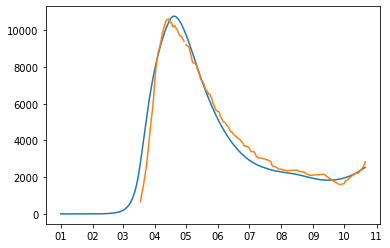

Deaths


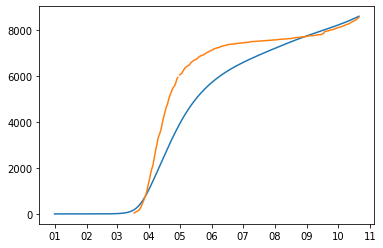

ICUs


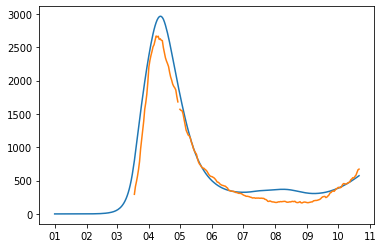

0.6872593497384267

In [19]:
error([76, 0.38739075911496973, 0.5992679376967565, 0.9670094172035613, 0.0, 0.0, 0.2, 1.0, 1.6649637320414583, 0.5, 2.0, 1.131027110574965, 30])

In [20]:
error([76, 0.38739075911496973, 0.5992679376967565, 0.9670094172035613, 0.0, 0.0, 0.2, 1.0, 1.6649637320414583, 0.5, 2.0, 1.131027110574965, 30])

{'beds_total': 0.22535204014808535, 'beds_tail': 0.01462958354709912, 'beds_peak': 0.006960649720658113, 'icus_total': 0.2680423911543894, 'icus_tail': 0.07002223051263774, 'icus_peak': 0.01377657332174846, 'deaths_total': 0.2931594815164578, 'deaths_tail': 0.009359324501473943, 'deaths_peak': 0.09869772557745007}


0.6872593497384267

In [21]:
v = [76, 0.38739075911496973, 0.5992679376967565, 0.9670094172035613, 0.0, 0.0, 0.2, 1.0, 1.6649637320414583, 0.5, 2.0, 1.131027110574965, 30]
n_sample = 0

days_ahead = v[0]
alpha_mixing = v[1]

beta_normal = original_beta
beta_masks = beta_normal*v[2]

mix_1 = v[3]
mix_2 = 0

alphas_d = {
    'work':alpha_mixing,
    'transport':alpha_mixing,
    'school':alpha_mixing,
    'other':alpha_mixing,
    'leisure':alpha_mixing,
    'home':alpha_mixing,
}

# School lockdowns
school_lockdown = v[4]
school_may_jun = v[5]
school_jul_aug = v[6]
school_sep_oct = v[7]

# Changes to SEIR rates
fraction_p_ICU = v[8]
change_lambda_H_aft = v[9]
change_lambda_ICU_aft = v[10]
change_p_death_aft = v[11]

# Date that a change occurs
days_change_rates = v[12]


google['other'] = mix_1*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+(1-mix_1)*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
google['leisure'] = mix_2*(google["parks_percent_change_from_baseline"]+100)/100+(1-mix_2)*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100


# Number of days
days_before_date_1 = int(days_ahead)
days_between_dates_1_2 = (date_2-date_1).days
days_between_dates_2_3 = (date_3-date_2).days
days_between_dates_3_4 = (date_4-date_3).days
days_after_date_4 = (final_date-date_4).days
total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_after_date_4
validation_days = days_before_date_1 + (final_date-date_1).days

# Some additional calculations
days_rates_start = (rates_date - date_1).days + days_ahead

# Construct initialization
initialization = deepcopy(original_initialization)
for i,group in enumerate(age_groups):
    if group == "age_group_40_49":
        initialization[group]["I"] = initialization[group]["I"] + 1
        initialization[group]["S"] = initialization[group]["S"] - 1
    initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]


# Alphas
a_before_google = {
    'home':1.0,
    'leisure':1.0,
    'other':1.0,
    'school':1.0,
    'transport':1.0,
    'work':1.0
}



# Calculate alphas
alphas_vec = []
for t in range(days_before_date_1-days_between_google):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_before_google
    alphas_vec.append(alphas)

counter = 0
for t in range(days_between_google):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':1.0,
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)   
    counter += 1

for t in range(days_between_dates_1_2):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':school_lockdown*samples[n_sample,counter,2],
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)   
    counter += 1

for t in range(days_between_dates_2_3):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':school_may_jun*samples[n_sample,counter,2],
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)   
    counter += 1

for t in range(days_between_dates_3_4):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':school_jul_aug*samples[n_sample,counter,2],
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)   
    counter += 1

for t in range(days_after_date_4):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = {
            'home':1.0,
            'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
            'other':google['other'][counter]*samples[n_sample,counter,1],
            'school':school_sep_oct*samples[n_sample,counter,2],
            'transport':google['transport'][counter]*samples[n_sample,counter,3],
            'work':google['work'][counter]*samples[n_sample,counter,4],
        }
    alphas_vec.append(alphas)
    counter += 1

# Calculate tests
tests = np.zeros(len(age_groups))


# Run model
model_data_beds = {ag:[] for ag in age_groups+["total"]}
model_data_icus = {ag:[] for ag in age_groups+["total"]}
model_data_deaths = {ag:[] for ag in age_groups+["total"]}

state = state_to_matrix(initialization)
t_beds = 0
t_icus = 0
t_deaths = 0
for i,ag in enumerate(age_groups):
    state_H = state[i,cont.index("H")]
    state_ICU = state[i,cont.index("ICU")]
    state_D = state[i,cont.index("D")]
    model_data_beds[ag].append(state_H)
    model_data_icus[ag].append(state_ICU)
    model_data_deaths[ag].append(state_D)
    t_beds+= state_H
    t_icus+= state_ICU
    t_deaths+= state_D
model_data_beds["total"].append(t_beds)
model_data_icus["total"].append(t_icus)
model_data_deaths["total"].append(t_deaths)


dynModel.beta = np.zeros((len(age_groups),len(dynModel.groups[age_groups[0]].parameters["beta"])))
for i in range(len(age_groups)):
    for j in range(len(dynModel.groups[age_groups[0]].parameters["beta"])):
        if j < int(days_rates_start+days_change_rates):
            dynModel.beta[i,j] = beta_normal
        else:
            d_after = j-int(days_rates_start+days_change_rates)
            d_portion = max(trans_days-d_after,0)/trans_days
            dynModel.beta[i,j] = beta_normal*d_portion+beta_masks*(1-d_portion)

for t in range(total_days):
    current_date = date_1+timedelta(days=t-days_before_date_1)
    day_of_week = current_date.weekday()

    update_contacts = True

    if t<int(days_rates_start+days_change_rates):
        dynModel.p_H = initial_params["p_H"]
        dynModel.p_ICU = initial_params["p_ICU"]

        lambda_H = initial_params["lambda_H"]
        lambda_ICU = initial_params["lambda_ICU"]
        p_death = initial_params["p_death"]

        dynModel.lambda_H_D = p_death*lambda_H
        dynModel.lambda_H_R = (1-p_death)*lambda_H
        dynModel.lambda_ICU_D = p_death*lambda_ICU
        dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU

    else:
        d_after = t-int(days_rates_start+days_change_rates)
        d_portion = max(trans_days-d_after,0)/trans_days

        dynModel.p_ICU = initial_params["p_ICU"]*d_portion+initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion)
        dynModel.p_H = (initial_params["p_H"]+initial_params["p_ICU"])-(initial_params["p_ICU"]*d_portion+initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion))

        lambda_H = initial_params["lambda_H"]*d_portion+initial_params["lambda_H"]*change_lambda_H_aft*(1-d_portion)
        lambda_ICU = initial_params["lambda_ICU"]*d_portion+ initial_params["lambda_ICU"]*change_lambda_ICU_aft*(1-d_portion)
        p_death = initial_params["p_death"]*d_portion+initial_params["p_death"]*change_p_death_aft*(1-d_portion)

        dynModel.lambda_H_D = p_death*lambda_H
        dynModel.lambda_H_R = (1-p_death)*lambda_H
        dynModel.lambda_ICU_D = p_death*lambda_ICU
        dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU




    season = "spc"
    dynModel.mixing_method = {
            "name":"mult",
            "param_alpha":alphas_d,
            "param_beta":alphas_d,
        }

    state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]), t, season, update_contacts=update_contacts)
    t_beds = 0
    t_icus = 0
    t_deaths = 0
    for i,ag in enumerate(age_groups):
        state_H = state[i,cont.index("H")]
        state_ICU = state[i,cont.index("ICU")]
        state_D = state[i,cont.index("D")]
        model_data_beds[ag].append(state_H)
        model_data_icus[ag].append(state_ICU)
        model_data_deaths[ag].append(state_D)
        t_beds+= state_H
        t_icus+= state_ICU
        t_deaths+= state_D
        print(np.sum(dynModel.get_new_infections_old()))
    #print(t_beds)
    model_data_beds["total"].append(t_beds)
    model_data_icus["total"].append(t_icus)
    model_data_deaths["total"].append(t_deaths)


initial_date = date_1-timedelta(days=days_before_date_1)

# Calculate the days of the model
days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

# Indices where to put the real data
indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in french_days]

# Real data
real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}

for k,ind in enumerate(indices):
    for ag in age_groups+["total"]:
        real_data_beds[ag][ind] = beds_real[ag][k] if beds_real[ag][k]!=0 else float('nan')
        real_data_icus[ag][ind] = icus_real[ag][k] if icus_real[ag][k]!=0 else float('nan')
        real_data_deaths[ag][ind] = deaths_real[ag][k] if deaths_real[ag][k]!=0 else float('nan')


tail_constant = 0.5
peak_constant = 0.25
error_beds = 0
error_icus = 0
error_deaths = 0

peak_beds = np.nanargmax(np.array(real_data_beds["total"]))
peak_icus = np.nanargmax(np.array(real_data_icus["total"]))
peak_deaths = peak_beds+30

#         for ag in old_age_groups:
#             error_beds += np.nanmean((np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag]))/np.array(real_data_beds[ag]))[0:validation_days-1])
#             error_icus += np.nanmean((np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag]))/np.array(real_data_icus[ag]))[0:validation_days-1])
#             error_deaths += np.nanmean((np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag]))/np.array(real_data_deaths[ag]))[0:validation_days-1])
error_beds_total = np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[0:validation_days-14])
error_beds_tail = tail_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[validation_days-14:validation_days])
error_beds_peak = peak_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[peak_beds:peak_beds+1])

error_icus_total = 0.5*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[0:validation_days-14])
error_icus_tail = 2*tail_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[validation_days-14:validation_days])
error_icus_peak = 0.5*peak_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[peak_icus:peak_icus+1])


error_deaths_total = np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[0:validation_days-14])
error_deaths_tail = tail_constant*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[validation_days-14:validation_days])
error_deaths_peak = peak_constant*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_deaths:peak_deaths+1])
#         error_deaths_total += error_constant/4.0*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_beds:peak_beds+1])

#overflow = np.array(model_data_icus["total"]) - icu_bound
#overflow_error = np.nanmean([max(overflow[i],0) for i in range(len(overflow))])


upper_days_model = days_model

error = error_beds_total+error_beds_tail+error_beds_peak+error_icus_total+error_icus_tail+error_icus_peak+error_deaths_total+error_deaths_tail+error_deaths_peak

error_dict = {
    "beds_total":error_beds_total/error,
    "beds_tail":error_beds_tail/error,
    "beds_peak":error_beds_peak/error,
    "icus_total":error_icus_total/error,
    "icus_tail":error_icus_tail/error,
    "icus_peak":error_icus_peak/error,
    "deaths_total":error_deaths_total/error,
    "deaths_tail":error_deaths_tail/error,
    "deaths_peak":error_deaths_peak/error,
}
print(error_dict)
print(error)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.028790452196637964
0.028790452196637964
0.028790452196637964
0.028790452196637964
0.028790452196637964
0.028790452196637964
0.028790452196637964
0.028790452196637964
0.028790452196637964
0.04318567732693186
0.04318567732693186
0.04318567732693186
0.04318567732693186
0.04318567732693186
0.04318567732693186
0.04318567732693186
0.04318567732693186
0.04318567732693186
0.053470473417471506
0.053470473417471506
0.053470473417471506
0.053470473417471506
0.053470473417471506
0.053470473417471506
0.053470473417471506
0.053470473417471506
0.053470473417471506
0.0632436465105901
0.0632436465105901
0.0632436465105901
0.0632436465105901
0.0632436465105901
0.0632436465105901
0.0632436465105901
0.0632436465105901
0.0632436465105901
0.07387454881484465
0.07387454881484465
0.07387454881484465
0.07387454881484465
0.07387454881484465
0.07387454881484465
0.07387454881484465
0.07387454881484465
0.07387454881484465
0.08600370357163785
0.08600370357163785
0.0860037035716

862.9264863891655
862.9264863891655
862.9264863891655
862.9264863891655
862.9264863891655
862.9264863891655
862.9264863891655
862.9264863891655
862.9264863891655
811.0934347926475
811.0934347926475
811.0934347926475
811.0934347926475
811.0934347926475
811.0934347926475
811.0934347926475
811.0934347926475
811.0934347926475
784.9976696186637
784.9976696186637
784.9976696186637
784.9976696186637
784.9976696186637
784.9976696186637
784.9976696186637
784.9976696186637
784.9976696186637
750.8740918370682
750.8740918370682
750.8740918370682
750.8740918370682
750.8740918370682
750.8740918370682
750.8740918370682
750.8740918370682
750.8740918370682
721.3384173273654
721.3384173273654
721.3384173273654
721.3384173273654
721.3384173273654
721.3384173273654
721.3384173273654
721.3384173273654
721.3384173273654
692.8077473033456
692.8077473033456
692.8077473033456
692.8077473033456
692.8077473033456
692.8077473033456
692.8077473033456
692.8077473033456
692.8077473033456
635.805513586681
635.8055135

441.63080141092934
441.63080141092934
442.3817971694186
442.3817971694186
442.3817971694186
442.3817971694186
442.3817971694186
442.3817971694186
442.3817971694186
442.3817971694186
442.3817971694186
446.8668453854412
446.8668453854412
446.8668453854412
446.8668453854412
446.8668453854412
446.8668453854412
446.8668453854412
446.8668453854412
446.8668453854412
452.3321135754511
452.3321135754511
452.3321135754511
452.3321135754511
452.3321135754511
452.3321135754511
452.3321135754511
452.3321135754511
452.3321135754511
457.76029822749166
457.76029822749166
457.76029822749166
457.76029822749166
457.76029822749166
457.76029822749166
457.76029822749166
457.76029822749166
457.76029822749166
462.424935780713
462.424935780713
462.424935780713
462.424935780713
462.424935780713
462.424935780713
462.424935780713
462.424935780713
462.424935780713
466.7777089915595
466.7777089915595
466.7777089915595
466.7777089915595
466.7777089915595
466.7777089915595
466.7777089915595
466.7777089915595
466.7777

574.1920063961536
574.1920063961536
574.1920063961536
574.1920063961536
574.1920063961536
574.1920063961536
574.1920063961536
574.1920063961536
574.1920063961536
585.2042213733796
585.2042213733796
585.2042213733796
585.2042213733796
585.2042213733796
585.2042213733796
585.2042213733796
585.2042213733796
585.2042213733796
599.9953600239187
599.9953600239187
599.9953600239187
599.9953600239187
599.9953600239187
599.9953600239187
599.9953600239187
599.9953600239187
599.9953600239187
614.8310544790107
614.8310544790107
614.8310544790107
614.8310544790107
614.8310544790107
614.8310544790107
614.8310544790107
614.8310544790107
614.8310544790107
629.5019765686751
629.5019765686751
629.5019765686751
629.5019765686751
629.5019765686751
629.5019765686751
629.5019765686751
629.5019765686751
629.5019765686751
640.7934454540103
640.7934454540103
640.7934454540103
640.7934454540103
640.7934454540103
640.7934454540103
640.7934454540103
640.7934454540103
640.7934454540103
656.5829858889248
656.582985